In [1]:
import cv2
import os
import skimage
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

import utils
import orb

In [13]:
def surf_match(src, tar):
    detector = cv2.xfeatures2d.SURF_create(10000)
    kpts1, desc1 = detector.detectAndCompute(src, None)
    kpts2, desc2 = detector.detectAndCompute(tar, None)

    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
    nn_matches = matcher.knnMatch(desc1, desc2, 2)
    
    return kpts1, kpts2, nn_matches

In [4]:
def estimate_matrix(kpts1, kpts2, nn_matches, nn_match_ratio=0.95, min_match_count=4):

    # good match
    gd_matches = [m for m, n in nn_matches if m.distance<n.distance*nn_match_ratio] 

    matrix = np.array([[0, 0, 0], [0, 0, 0]])
    match_mask = None

    if len(gd_matches) >= min_match_count:

        src_pts = np.float32([kpts1[m.queryIdx].pt for m in gd_matches]).reshape(-1, 1, 2)
        tar_pts = np.float32([kpts2[m.trainIdx].pt for m in gd_matches]).reshape(-1, 1, 2)

        matrix, ransac_mask = cv2.estimateAffinePartial2D(src_pts, tar_pts)
        match_mask = ransac_mask.ravel().tolist()

    return matrix, match_mask

In [2]:
im_a_path = '/data1/huangkaibin/Data/karyotype/origin_split/a_crop/'
im_k_path = '/data1/huangkaibin/Data/karyotype/origin_split/k/'

im_a_name = sorted(list(os.listdir(im_a_path)))
im_k_name = sorted(list(os.listdir(im_k_path)))

kernel = np.ones((5, 5), np.uint8)

# def preprocess_img()

for name in im_a_name[:1]:
    im_a = cv2.imread(os.path.join(im_a_path, name), 0)
    im_k = cv2.imread(os.path.join(im_k_path, name.replace('A.TIF', 'K.TIF')), 0)
    
    mask_k = utils.threshold_segm(im_k, 250)
    
    for prop in regionprops(label(mask_k)):
#         sub_im_k = im_k[prop.bbox[0]:prop.bbox[2], prop.bbox[1]:prop.bbox[3]]
#         sub_mask_k = mask_k[prop.bbox[0]:prop.bbox[2], prop.bbox[1]:prop.bbox[3]]
        sub_im_k = utils.show_spec_area(im_k, prop.bbox, 255)
        sub_mask_k = utils.show_spec_area(mask_k, prop.bbox, 0)
        if sub_mask_k.sum()/255 > 200:
            sub_mask = utils.fill_holes(sub_mask_k)
            sub_mask_erode = cv2.erode(sub_mask, kernel)
            
            labels = label(sub_mask_erode)
            props  = regionprops(labels)
            
            if len(props) > 1:
                print('1')
                obj_ids = np.unique(labels)
                obj_ids = obj_ids[1:]
                labels = labels == obj_ids[:, None, None]

                for l in labels:
                    l = cv2.dilate(255*l.astype(np.uint8), kernel)
                    px, py = np.where(l)
                    xmin = np.min(px)
                    xmax = np.max(px)
                    ymin = np.min(py)
                    ymax = np.max(py)
                    
                    if l.sum()/255 > 200:
                        sub_im_k_split = sub_im_k[xmin:xmax, ymin:ymax]
#                         s_x, s_y = sub_im_k_split.shape[:2]
                        kpts1, kpts2, nn_matches = image_match(sub_im_k_split, im_a, 'surf')
                        matrix, match_mask = orb.estimate_matrix(kpts1, kpts2, nn_matches)
#                         print(0 if not match_mask else len(match_mask))
                        match_draw = cv2.drawMatches(sub_im_k_split, kpts1, im_a, kpts2, nn_matches, None)
            else:
                kpts1, kpts2, nn_matches = image_match(sub_im_k, im_a, 'surf')
#                 matrix, match_mask = orb.estimate_matrix(kpts1, kpts2, nn_matches)
#                 print(0 if not match_mask else len(match_mask))
                good = []
                for m, n in nn_matches:
                    if m.distance < 0.75 * n.distance:
                        good.append(m)
                match_draw = cv2.drawMatches(sub_im_k, kpts1, im_a, kpts2, good, None)
                plt.imshow(match_draw)
                plt.show()


NameError: name 'image_match' is not defined

In [2]:
surf = cv2.xfeatures2d.SURF_create(500)
kpts1, desc1 = surf.detectAndCompute(src, None)
kpts2, desc2 = surf.detectAndCompute(tar, None)

matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
nn_matches = matcher.knnMatch(desc1, desc2, 2)

<xfeatures2d_SURF 0x7f30386189b0>

In [ ]:
def orb_match(src, tar):
    detector = cv2.ORB_create(10000)
    kpts1 = detector.detect(src, None)
    kpts2 = detector.detect(tar, None)

    descriptor = cv2.xfeatures2d.BEBLID_create(0.75)

    kpts1, desc1 = descriptor.compute(src, kpts1)
    kpts2, desc2 = descriptor.compute(tar, kpts2)

    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
    nn_matches = matcher.knnMatch(desc1, desc2, 2)

    return kpts1, kpts2, nn_matches

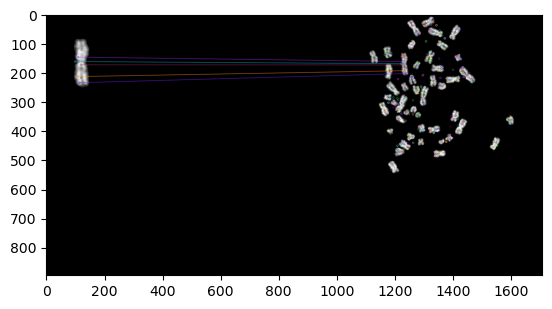

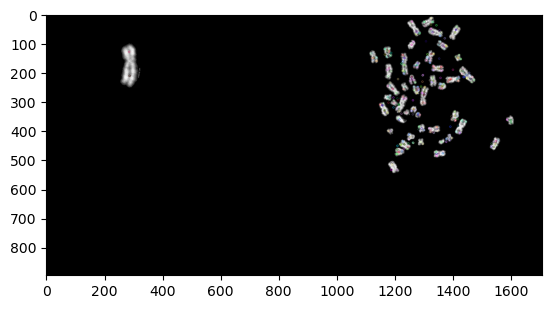

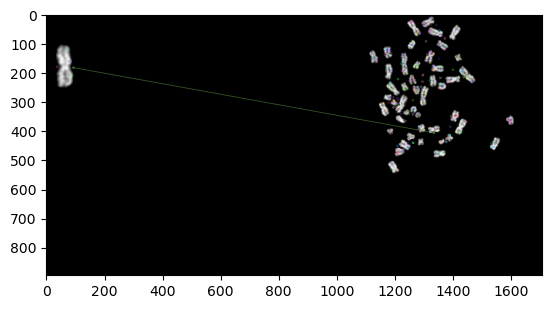

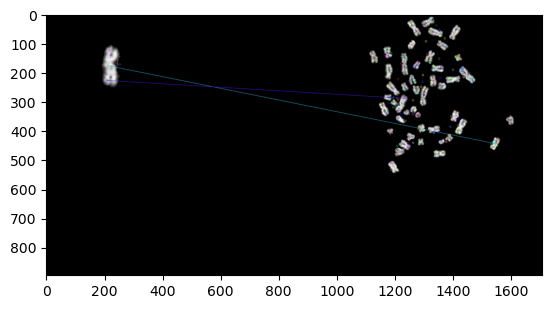

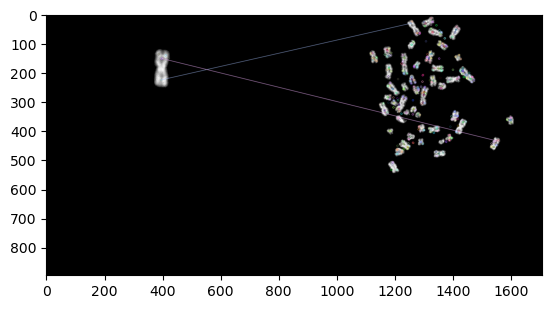

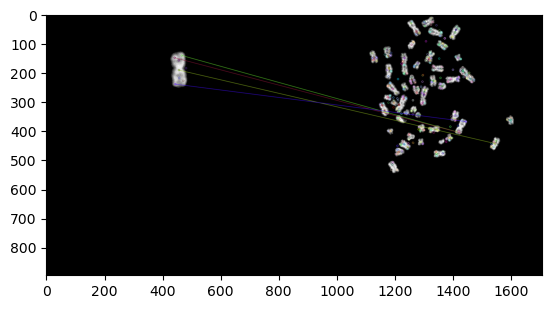

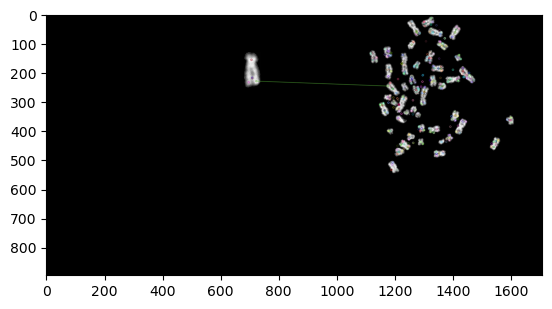

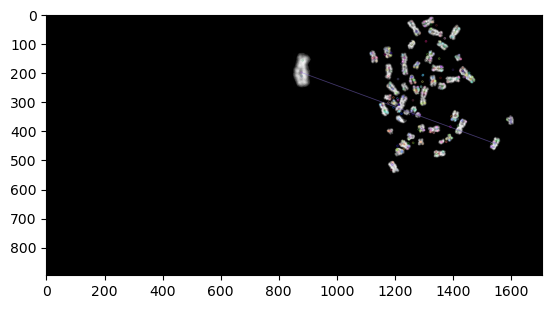

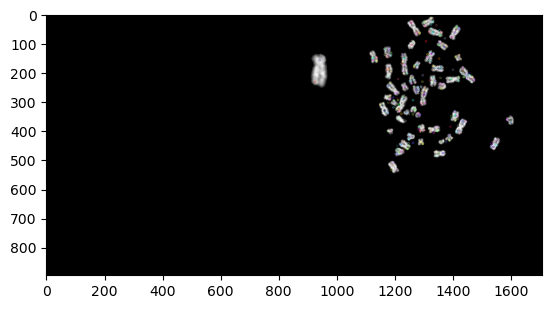

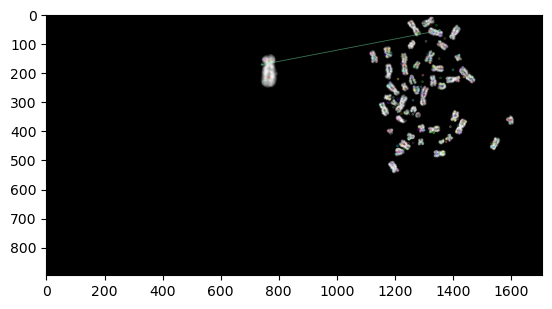

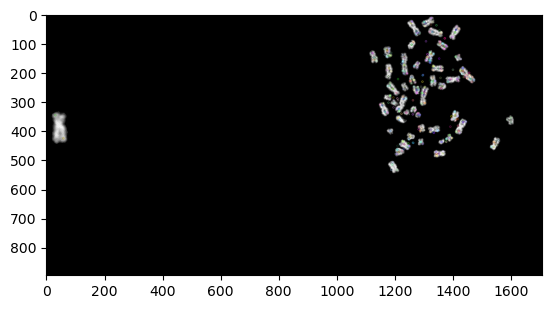

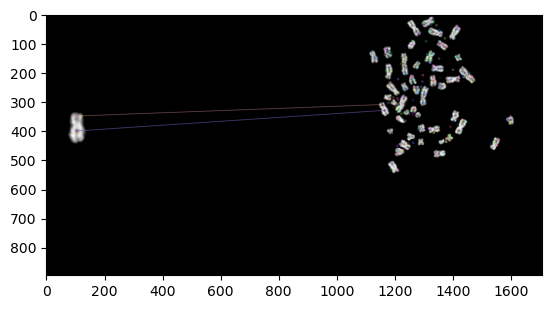

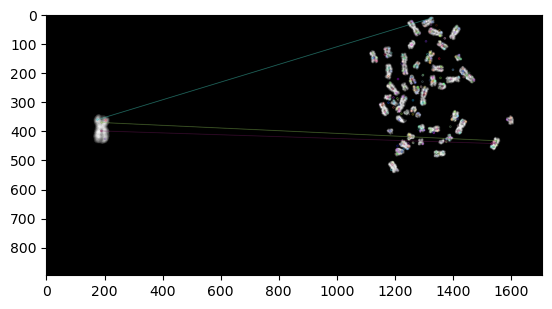

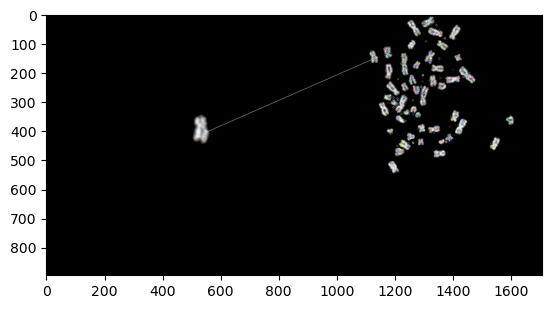

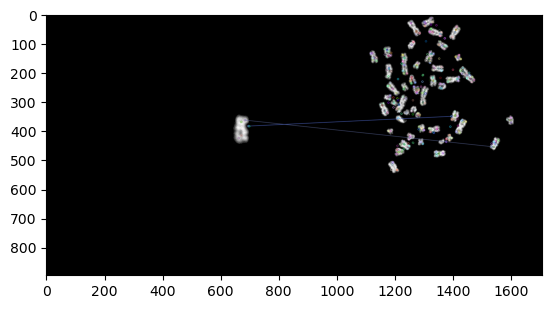

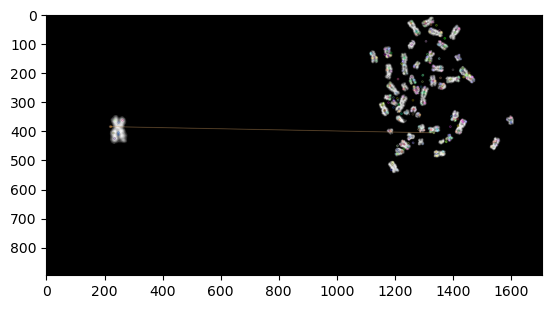

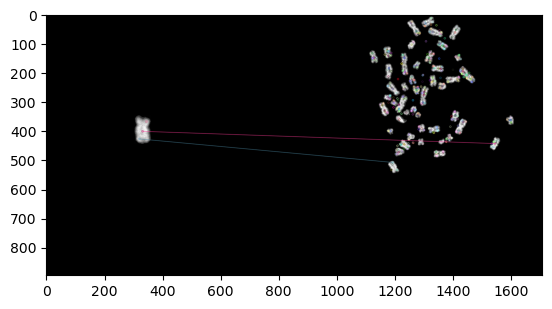

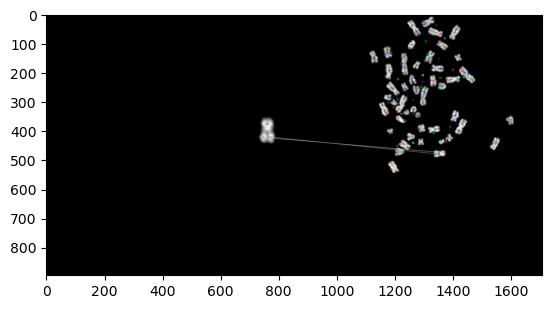

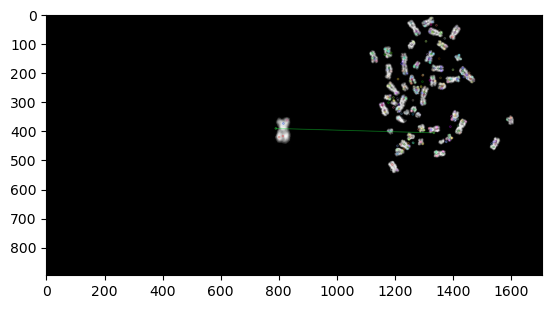

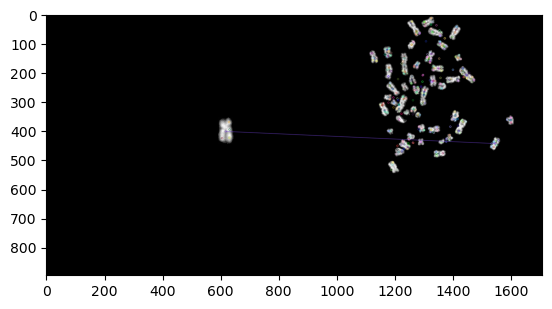

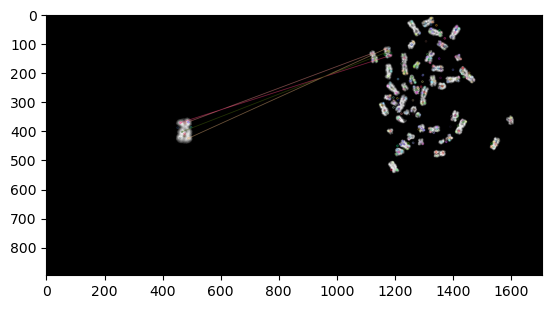

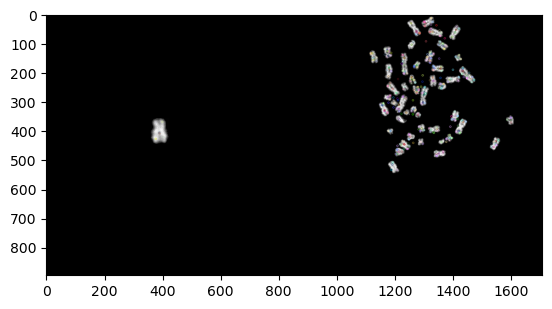

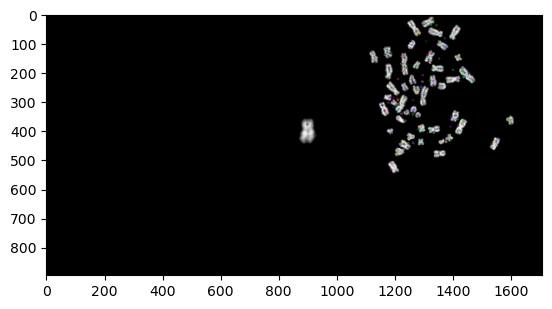

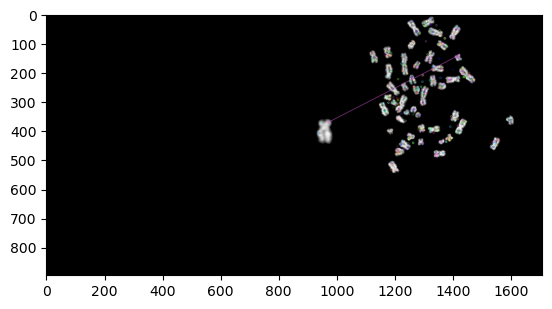

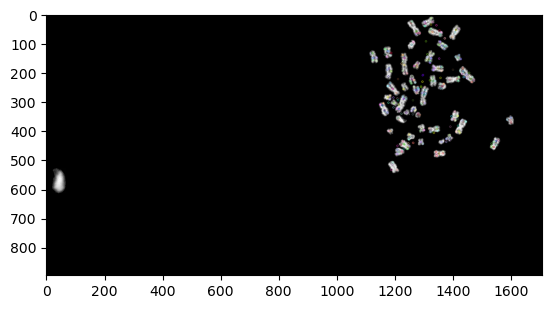

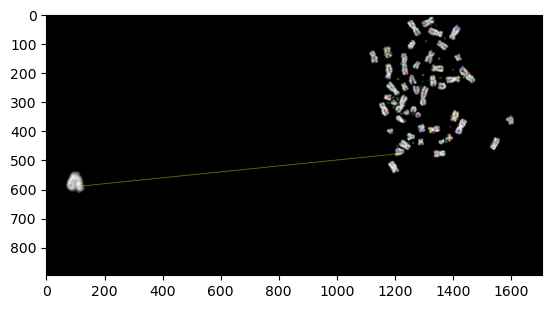

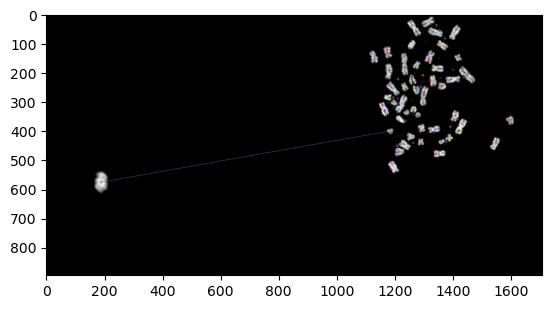

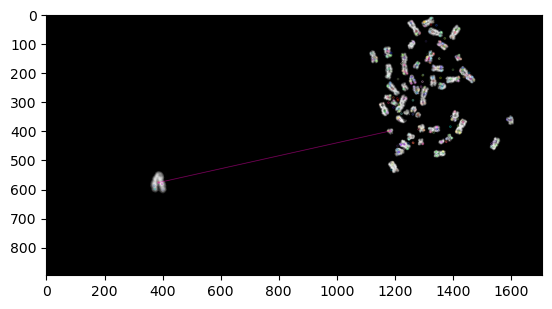

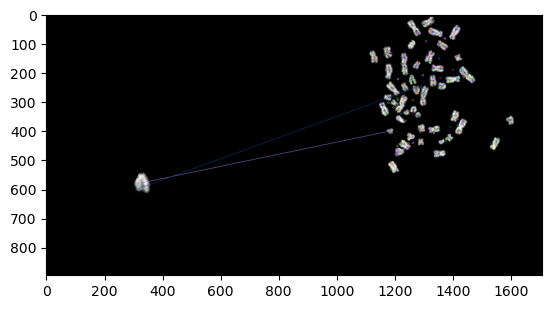

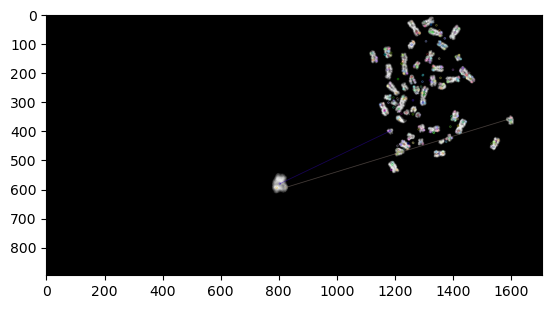

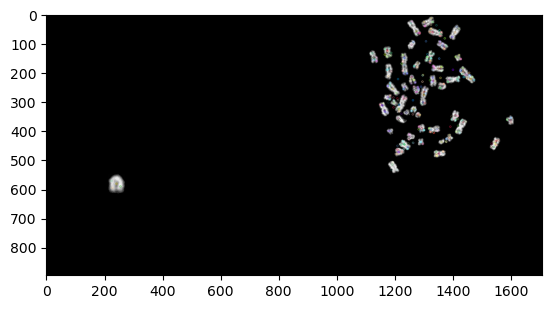

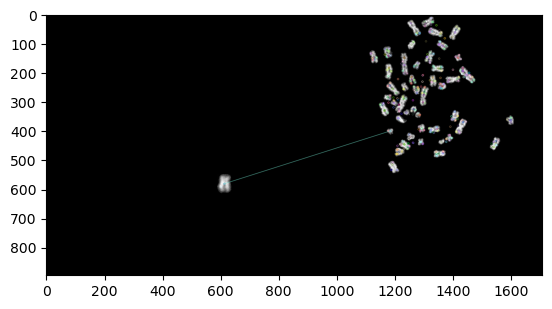

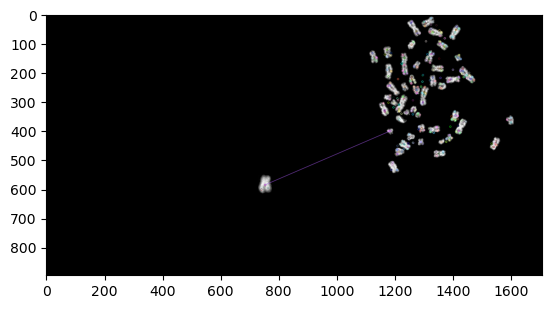

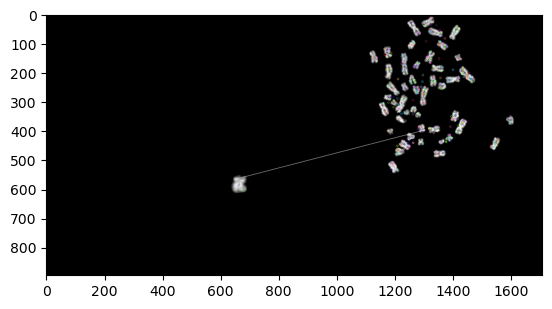

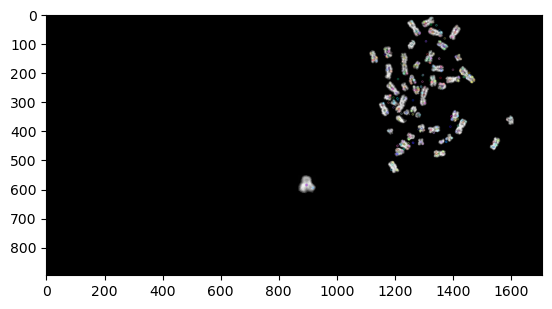

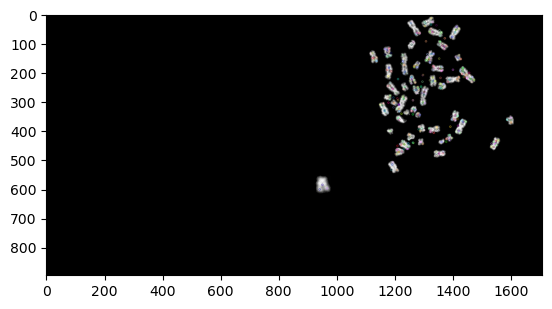

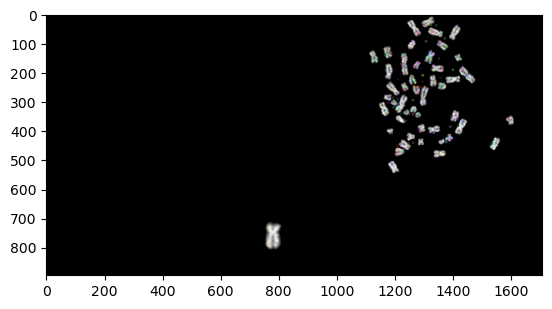

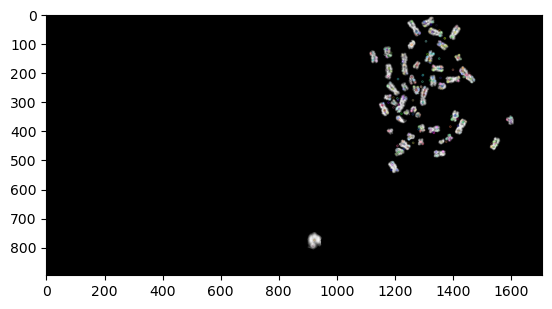

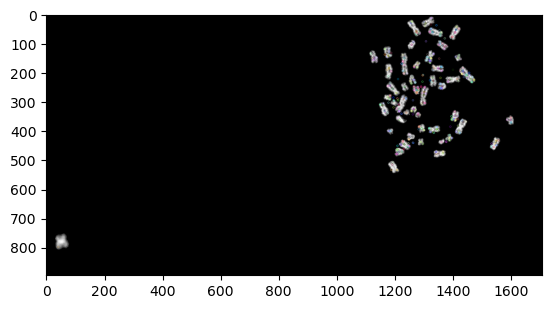

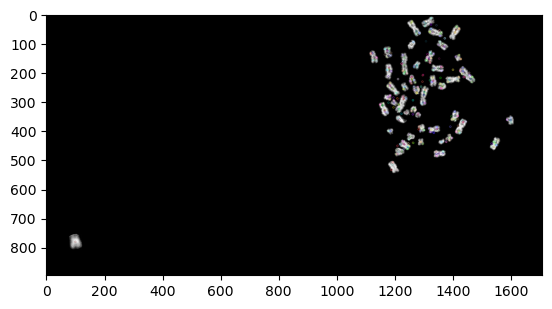

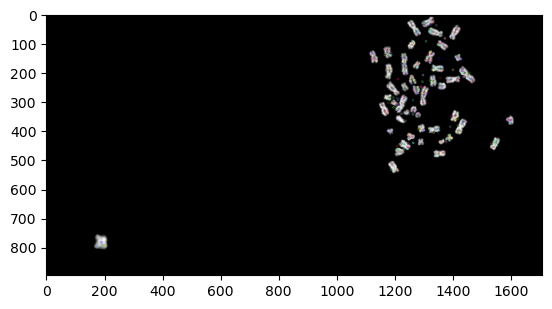

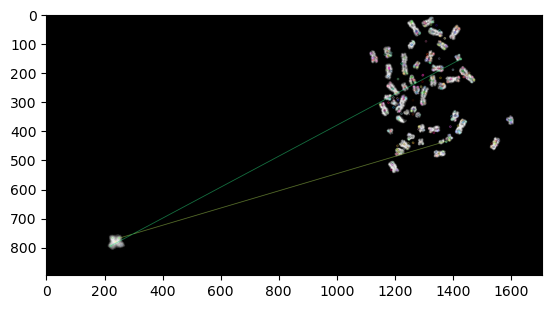

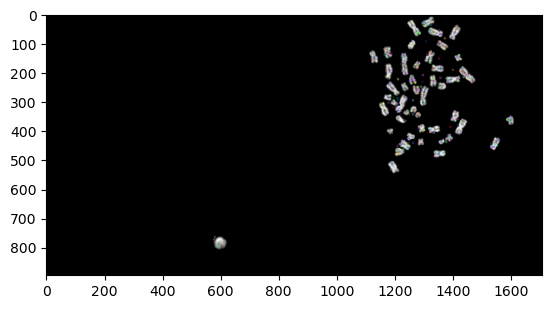

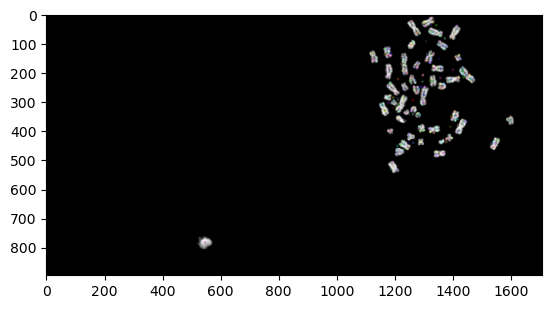

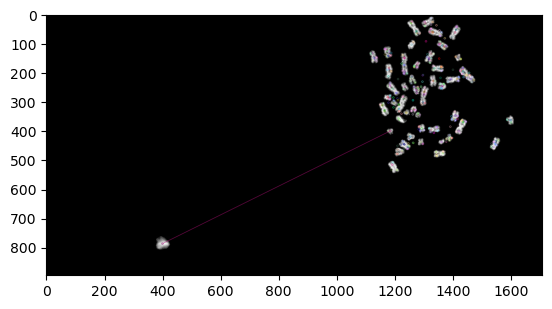

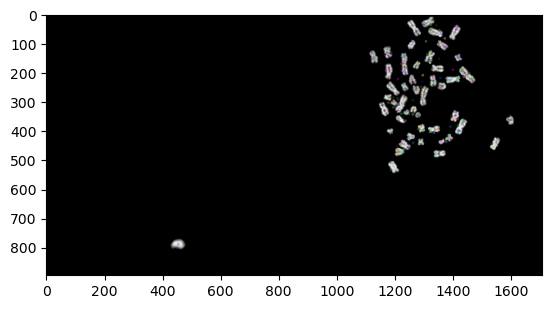

In [13]:
im_a_path = '/data1/huangkaibin/Data/karyotype/origin_split/a_crop/'
im_k_path = '/data1/huangkaibin/Data/karyotype/origin_split/k/'

im_a_name = sorted(list(os.listdir(im_a_path)))
im_k_name = sorted(list(os.listdir(im_k_path)))

k_sharpen = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]], np.float32)
k_erode = np.ones((5, 5), np.uint8)

for name in im_a_name[:1]:
    im_a = cv2.imread(os.path.join(im_a_path, name), 0)
    im_k = cv2.imread(os.path.join(im_k_path, name.replace('A.TIF', 'K.TIF')), 0)
    
    im_a = cv2.filter2D(im_a, -1, k_sharpen)
    im_a = 255 - im_a

    mask_k = utils.threshold_segm(im_k, 250)
    
    for prop in regionprops(label(mask_k)):
#         sub_im_k = im_k[prop.bbox[0]:prop.bbox[2], prop.bbox[1]:prop.bbox[3]]
#         sub_mask_k = mask_k[prop.bbox[0]:prop.bbox[2], prop.bbox[1]:prop.bbox[3]]
        sub_im_k = utils.show_spec_area(im_k, prop.bbox, 255)
        sub_im_k = cv2.filter2D(sub_im_k, -1, k_sharpen)
        sub_mask_k = utils.show_spec_area(mask_k, prop.bbox, 0)
        if sub_mask_k.sum()/255 > 200:
#             sub_mask_k = utils.fill_holes(sub_mask_k)
            
            detector = cv2.xfeatures2d.SURF_create(10000)
#             detector = cv2.ORB_create(10000)
            
            sub_im_k = 255 - sub_im_k
            kpts1, desc1 = detector.detectAndCompute(sub_im_k, None)
            kpts2, desc2 = detector.detectAndCompute(im_a, None)

#             matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
#             print(desc1.dtype)
            matcher = cv2.BFMatcher(cv2.NORM_L1)
            nn_matches = matcher.knnMatch(desc1, desc2, 2)
            
            good = []
            for m, n in nn_matches:
                if m.distance < 0.75 * n.distance:
                    good.append(m)
            match_draw = cv2.drawMatches(sub_im_k, kpts1, im_a, kpts2, good, None)
            plt.imshow(match_draw)
            plt.show()